Load Dataset 

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/csat-project/eCommerce_Customer_support_data (1).csv")
df.head()


,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


Missing Values & Datatypes

In [2]:
# Handle missing values safely (no chained assignment)

df["Customer Remarks"] = df["Customer Remarks"].fillna("")

df["Item_price"] = df["Item_price"].fillna(df["Item_price"].median())
df["connected_handling_time"] = df["connected_handling_time"].fillna(
    df["connected_handling_time"].median()
)

# Verify output
print("Missing values after cleaning:")
print(df[["Item_price", "connected_handling_time"]].isnull().sum())


Missing values after cleaning:
Item_price                 0
connected_handling_time    0
dtype: int64


 Exploratory Data Analysis

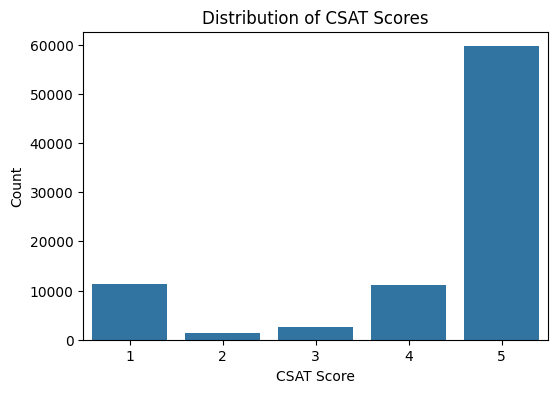

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df["CSAT Score"])
plt.title("Distribution of CSAT Scores")
plt.xlabel("CSAT Score")
plt.ylabel("Count")
plt.show()


Target Conversion & Column Selection

In [4]:
# Convert CSAT Score to binary target
# 1 = Not Satisfied (<=3), 0 = Satisfied (>=4)

df["csat_binary"] = df["CSAT Score"].apply(lambda x: 1 if x <= 3 else 0)

# Drop unnecessary columns
drop_cols = [
    "Unique id",
    "Order_id",
    "Agent_name",
    "Supervisor",
    "Manager",
    "CSAT Score"
]

df = df.drop(columns=drop_cols)

# Verify
df[["csat_binary"]].value_counts()


csat_binary
0              70836
1              15071
Name: count, dtype: int64

Text Processing

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,
    stop_words="english"
)

X_text = tfidf.fit_transform(df["Customer Remarks"]).toarray()

print("Text feature shape:", X_text.shape)


Text feature shape: (85907, 3000)


Encode Categorical + Scale Numeric Features

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Categorical columns to encode
cat_cols = [
    "channel_name",
    "category",
    "Sub-category",
    "Product_category",
    "Tenure Bucket",
    "Agent Shift"
]

# Label encode categorical columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Numeric columns
num_cols = ["Item_price", "connected_handling_time"]

X_num = df[cat_cols + num_cols]

# Scale numeric + encoded categorical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine numeric + text features
X = np.hstack((X_num_scaled, X_text))
y = df["csat_binary"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (68725, 3008)
Testing shape: (17182, 3008)


Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.7499708997788384
              precision    recall  f1-score   support

           0       0.89      0.80      0.84     14168
           1       0.35      0.52      0.42      3014

    accuracy                           0.75     17182
   macro avg       0.62      0.66      0.63     17182
weighted avg       0.79      0.75      0.77     17182



Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.7688278430916075
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     14168
           1       0.36      0.39      0.37      3014

    accuracy                           0.77     17182
   macro avg       0.61      0.62      0.62     17182
weighted avg       0.78      0.77      0.77     17182



Build DeepCSAT Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


2026-02-01 09:18:56.683513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769937536.935160     188 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769937537.005541     188 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769937537.572959     188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769937537.573027     188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769937537.573030     188 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,540,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,708,033 (6.52 MB)

 Trainable params: 1,706,497 (6.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

Train with Class Weights

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)


Class weights: {0: np.float64(0.6063827909931531), 1: np.float64(2.850004146968566)}
Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5719 - loss: 0.7402 - val_accuracy: 0.7716 - val_loss: 0.5499
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7048 - loss: 0.5954 - val_accuracy: 0.7879 - val_loss: 0.5528
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7359 - loss: 0.5683 - val_accuracy: 0.7336 - val_loss: 0.5936
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7583 - loss: 0.5478 - val_accuracy: 0.7117 - val_loss: 0.5975
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7609 - loss: 0.5455 - val_accuracy: 0.7515 - val_loss: 0.6052
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7612 - loss: 0.5381 - val_accuracy: 0.7905 - val_loss: 0.5772
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7979 - loss: 0.5278 - val_accuracy: 0.7828 - val_loss: 0.5545
Epoch

DeepCSAT Evaluation

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test data
y_pred_dl = (model.predict(X_test) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dl))


537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 0.7973460598300547

Confusion Matrix:
 [[12414  1754]
 [ 1728  1286]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     14168
           1       0.42      0.43      0.42      3014

    accuracy                           0.80     17182
   macro avg       0.65      0.65      0.65     17182
weighted avg       0.80      0.80      0.80     17182



Test Prediction with Sample Input

In [13]:
sample_review = "The agent was rude and did not resolve my issue"

# Select only trained features
feature_cols = cat_cols + num_cols
sample_row = df[feature_cols].iloc[0].values

# Transform inputs
review_vec = tfidf.transform([sample_review]).toarray()
num_scaled = scaler.transform([sample_row])

# Combine features
X_sample = np.hstack((num_scaled, review_vec))

prediction = model.predict(X_sample)

print("Raw prediction:", prediction)
print("Predicted CSAT:",
      "Not Satisfied ❌" if prediction > 0.5 else "Satisfied ✅")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Raw prediction: [[0.9899518]]
Predicted CSAT: Not Satisfied ❌


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Save Files

In [15]:
import joblib

# Save model in native Keras format (recommended)
model.save("/kaggle/working/deepcsat_model.keras")

# Save preprocessing objects
joblib.dump(tfidf, "/kaggle/working/tfidf.pkl")
joblib.dump(scaler, "/kaggle/working/scaler.pkl")

print("Model and preprocessors saved successfully!")


Model and preprocessors saved successfully!
